## Redes Neuronales - Parte II

En esta actividad vamos a aprender a desarrollar una red neuronal profunda para reconocimiento de imagenes. 

Además vamos a estudiar algunos detalles de implementación que nos ayudarán a organizar nuestro codigo y hacerlo más eficiente. 

Por otro lado, vamos a aprender a utilizar Callbacks para detener el proceso de entrenamiento antes de tiempo si llegamos a un objetivo deseado.

Para ello, vamos a trabajar con un dataset provisto por keras: Fashion MNIST. El dataset Fashion MNIST consta de 70.000 imágenes en escala de grises de 28x28 que pertenecen a una de 10 clases de prendas de vestir diferentes. 
El dataset se divide en 60.000 imagenes que se encuentran en el dataset de entrenamiento y 10.000 en el dataset de testeo.


Cada imagen representa una prenda de vestir de una de las siguientes categorías: 

                                0. T-shirt/top
                                1. Trouser
                                2. Pullover
                                3. Dress
                                4. Coat
                                5. Sandal
                                6. Shirt
                                7. Sneaker
                                8. Bag
                                9. Ankle boot 

Cada pixel tiene un valor asociado entre 0 y 255 que indica la luminosidad u oscuridad de dicho pixel (valores mas grandes indican mayor oscuridad).

El dataset tiene 785 columnas, en donde la primera columna es el label del dataset y las columnas restantes son los features que indican los valores de cada pixel de la imagen.

La idea es utilizar este dataset para reconocer prendas de vestir utilizando una red neuronal con varias layers y neuronas. Para ello, vamos a necesitar definir un modelo de clasificación multiclase.

En primer lugar, carguemos en memoria el dataset, obteniendo el dataset de entrenamiento y el de testeo e imprimamos sus dimensiones.


#### Ejercicio 1
a) Escribir en Python un programa para obtener del framework Keras el dataset Fashion MNIST dividido en dataset entrenamiento (x_train, y_train) y dataset de testeo (x_test, y_test).

**AYUDA:** el dataset fashion_mnist se encuentra dentro de la libreria keras.datasets. Keras provee una forma de obtener el dataset dividido en entrenamiento y testeo con el método [.load_data() ](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data#expandable-1).

In [1]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

2024-04-13 20:49:39.854505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 20:49:39.854528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 20:49:39.855176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 20:49:40.469983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


b) Imprimir las dimensiones de todos los datasets (x_train, y_train, x_test, y test)

In [2]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

#### Ejercicio 2
a) Imprimir dos imagenes cualquiera utilizando matplotlib.

**AYUDA:** Recordemos que para imprimir una imagen con matplotlib se puede utilizar el metodo [.imshow(image)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow), siendo image el vector que contiene los 784 pixeles de la imagen.

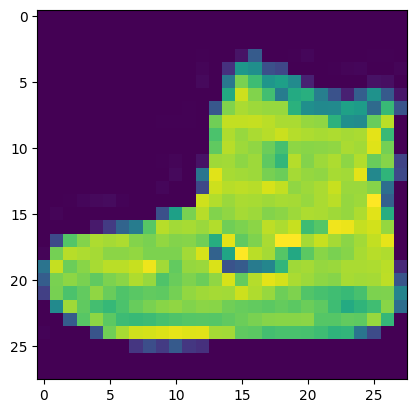

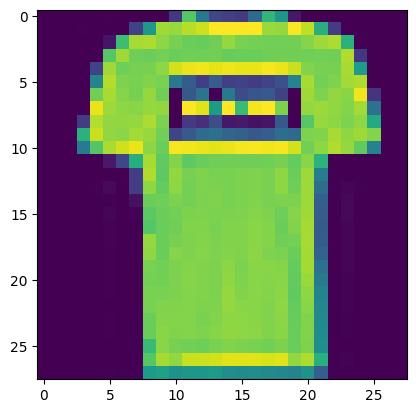

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[0])
plt.show()

plt.imshow(x_train[1])
plt.show()

#### Ejercicio 3
a) Normalizar los valores de los features en los datasets de entrenamiento y testeo (x_train y x_test) dividiendo los valores de los pixeles por 255.

In [4]:
x_train = x_train / 255
x_test = x_test / 255

### Callbacks

Los Callbacks de Keras son objetos que realizan acciones en diferentes etapas del proceso de entrenamiento (por ejemplo, al comienzo o al final de un epoch). En general se utilizan para escribir logs (registros) para monitorear el proceso, almacenar el modelo en disco periodicamente, detener el proceso de entrenamiento antes de lo previsto, entre otros.

El codigo para crear un nuevo Callback en Tensorflow/Keras que cancele el entrenamiento por haber obtenido un valor máximo de rendimiento es el siguiente:

```
class callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") > MAX_ACC:
            self.model.stop_training = True
```

Los callbacks creados son pasados en el método .fit().

#### Ejercicio 4
a) Crear una clase callback que detenga el proceso de entrenamiento cuando se llega al final de un epoch si es que se logra un .95 de accuracy e imprima el siguiente mensaje de aviso: "Se alcanzó el máximo de precisión y, por lo tanto, se canceló el proceso de entrenamiento."


In [5]:
import tensorflow as tf

class callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") > .95:
            self.model.stop_training = True
            print("Se alcanzó el máximo de precisión y, por lo tanto, se canceló el proceso de entrenamiento.")

### Ordenando el codigo
Ahora que tenemos los datasets de entrenamiento y testeo normalizados y observamos algunos ejemplos vamos a crear el modelo, compilarlo y entrenarlo. 

Para ello, vamos a crear un método que reuna todo el proceso completo:
1. Obtener el dataset de entrenamiento y de testeo (resuelto en Ejercicio 1.a.)
2. Normalizar los features de entrenamiento y testeo (resuelto en Ejercicio 3.)
3. Crear el modelo en Keras
4. Compilar el modelo (.compile(...))
5. Ajustar o entrenar (.fit(...)) el modelo pasandole el callback creado y almacenando el historial del proceso de entrenamiento.
6. Retornar el historial del proceso de entrenamiento y el modelo creado.

Para la **creación del modelo** vamos a utilizar una red neuronal con 4 layers ocultas: la primera con 512 neuronas, la segunda con 256 neuronas, la tercera con 128 neuronas y la cuarta con 64 neuronas. Como el problema es un problema de clasificación multiclase debemos utilizar al final la función softmax. Vamos a implementar la versión de codigo mejorada que vimos en el apunte, para ello, vamos a crear el modelo con la ultima layer con la función de activación lineal (para luego, fuera del metodo que estamos creando, aplicarle la función softmax para obtener las probabilidades por cada clase). Recordemos que como estamos trabajando con imagenes, la primera layer que debe tener nuestra red neuronal es la Layer Flatten().

Cuando realizamos la **compilación del modelo** vamos a usar de optimizador al algoritmo Adam (para ello, pasamos cmo parametro **optimizer='adam'**) y como metrica de evaluación vamos a usar accuracy (para ello, pasamos como parametro **metrics=['accuracy']**). Recordar que para clasificación multiclase debemos usar la función de costo **SparseCategoricalCrossentropy** con **from_logits=True** porque estamos implementando la versión mejorada del codigo, como vimos en el apunte.

Cuando relizamos el **entrenamiento del modelo** con el método .fit()  debemos pasarle el objeto callback creado (**callbacks=[myCallback]**). Además, la cantidad de epochs la vamos a setear en 100.

Tener en cuenta que el historial del proceso de entrenamiento es devuelto por el método .fit y se trata de un objeto History el cual en el atributo .history (History.history) se tiene un registro de los valores de error y de metricas obtenidas en los sucesivos epochs.

#### Ejercicio 5
a) Crear un método train_fashion_mnist() que se englobe los 6 pasos mencionados anteriormente. Notar que hay ciertos pasos que resolvimos en ejercicios anteriores que simplemente debemos copiar las lineas de código dentro del nuevo método.

In [6]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.nn import softmax

def train_fashion_mnist():
    # Creamos un objeto de la clase callbacks creada anteriormente
    myCallback = callbacks()

    # 1. Obtener el dataset de entrenamiento y de testeo (resuelto en Ejercicio 1) a.)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        
    # 2. Normalizar los features de entrenamiento y testeo (resuelto en Ejercicio 3.)
    x_train = x_train / 255
    x_test = x_test / 255   
    
    # 3. Crear el modelo en Keras
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])    
    
    # 4. Compilar el modelo (.compile(...))
    model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
    
    # 5. Ajustar o entrenar (.fit(...)) el modelo pasandole el callback creado y almacenando el historial del proceso de entrenamiento.
    history = model.fit(x_train, y_train, epochs=100, callbacks=[myCallback])
        
    # 6.Retornar el historial del proceso de entrenamiento.
    return history.history, model

Ahora que tenemos un método que es capaz de realizar todo el proceso completo lo unico que resta es realizar una llamada al mismo para obtener el objeto history y el model.

In [7]:
# El entrenamiento debería cortarse en aproximadamente 35 epochs
history, model = train_fashion_mnist()

2024-04-13 20:49:42.330607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 20:49:42.359393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 20:49:42.360791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2024-04-13 20:49:43.566573: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-13 20:49:43.629939: I external/local_xla/xla/service/service.cc:168] XLA service 0x78ed84102530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 20:49:43.629955: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-13 20:49:43.634212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 20:49:43.648775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1713052183.710609   33775 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 6s 2ms/step - loss: 0.4907 - accuracy: 0.8222
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3660 - accuracy: 0.8668
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3333 - accuracy: 0.8772
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3074 - accuracy: 0.8867
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2900 - accuracy: 0.8931
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2759 - accuracy: 0.8983
Epoch 7/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2638 - accuracy: 0.9012
Epoch 8/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2527 - accuracy: 0.9058
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2435 - accuracy: 0.9083
Epoch 10/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2329 

Hay que tener en cuenta que en el modelo creado, al no haber aplicado la función softmax aún, las salidas no son probabilidades, es decir, son valores que van de [-inf, +inf]. 

Veamos a continuación, los valores de salida para el primer ejemplo y además, observemos cuales son los valores maximos y minimos de todas las salidas para confirmar que no son probabilidades.

In [8]:
import numpy as np

prediction = model.predict(x_train)

print()
print(f"Valores de Salida para el primer ejemplo:\n {prediction[0]}")
print()
print("Valor máximo", np.max(prediction), "- Valor mínimo", np.min(prediction))

1875/1875 [==============================] - 2s 856us/step

Valores de Salida para el primer ejemplo:
 [-18.549755   -7.331433  -16.794378  -24.877846  -18.267038  -10.331398
 -17.21718     1.152229  -11.834721    5.7548785]

Valor máximo 368.3134 - Valor mínimo -1258.7012


Como puede verse, las predicciones de salida **no son probabilidades**. 

Si la salida deseada deben ser probabilidades, la salida del modelo debe ser procesada a través de una operación Softmax.

In [9]:
logit = model(x_train)
f_x = softmax(logit)

print()
print(f"Valores de Salida para el primer ejemplo:\n {f_x[0]}")
print()
print("Valor máximo", np.max(f_x), "- Valor mínimo", np.min(f_x))


Valores de Salida para el primer ejemplo:
 [2.75614791e-11 2.05284869e-06 1.59460445e-10 4.92097275e-14
 3.65666213e-11 1.02208737e-07 1.04480015e-10 9.92574543e-03
 2.27302870e-08 9.90072131e-01]

Valor máximo 1.0 - Valor mínimo 0.0


Como se observa, los valores de salida se encuentran en el rango [0,1]. Si sumamos las probabilidades para un ejemplo debería darnos como resultado 1.0. (Se puede modificar el indice y probar que efectivamente para cualquier ejemplo el resultado siempre es 1.0)


In [10]:
sum(f_x[0]).numpy()

1.0

### ¿Cómo obtener las categorías estimadas?
Para obtener que categoría que se estimó con el modelo para un ejemplo dado se debe seleccionar la categoría más probable. 

Para ello, es posible encontrar el índice de la salida con mayor probabilidad utilizando np.argmax(). 

A continuación se muestran las categorías estimadas y las reales para los 10 primeros ejemplos.

In [11]:
for i in range(10):
    print( f"Categoría Estimada: {np.argmax(f_x[i])}, Categoría Real: {y_train[i]}")

Categoría Estimada: 9, Categoría Real: 9
Categoría Estimada: 0, Categoría Real: 0
Categoría Estimada: 0, Categoría Real: 0
Categoría Estimada: 3, Categoría Real: 3
Categoría Estimada: 0, Categoría Real: 0
Categoría Estimada: 2, Categoría Real: 2
Categoría Estimada: 7, Categoría Real: 7
Categoría Estimada: 2, Categoría Real: 2
Categoría Estimada: 5, Categoría Real: 5
Categoría Estimada: 5, Categoría Real: 5
